In [5]:
!git clone https://github.com/tensorflow/magenta.git
!pip install svgwrite
!pip install magenta
!apt-get install build-essential libasound2-dev libjack-dev

Cloning into 'magenta'...
remote: Counting objects: 7591, done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 7591 (delta 1), reused 1 (delta 0), pack-reused 7570
Receiving objects: 100% (7591/7591), 26.85 MiB | 29.38 MiB/s, done.
Resolving deltas: 100% (5116/5116), done.
    100% |████████████████████████████████| 71kB 4.2MB/s 
    100% |████████████████████████████████| 1.1MB 7.1MB/s 
    100% |████████████████████████████████| 184kB 14.5MB/s 
    100% |████████████████████████████████| 225kB 13.2MB/s 
    100% |████████████████████████████████| 5.6MB 4.2MB/s 
    100% |████████████████████████████████| 71kB 22.3MB/s 
    100% |████████████████████████████████| 16.0MB 1.3MB/s 
    100% |████████████████████████████████| 81kB 23.1MB/s 
    4% |█▌                              | 71kB 24.8MB/s eta 0:00:01

    100% |████████████████████████████████| 1.6MB 9.1MB/s 
    100% |████████████████████████████████| 327kB 19.2MB/s 
    100% |████████████████████████████████| 1.9MB 12.1MB/s 
    9% |███                             | 1.5MB 34.0MB/s eta 0:00:01

    100% |████████████████████████████████| 15.9MB 1.2MB/s 
  Running setup.py bdist_wheel for python-rtmidi ... - \ | / - \ done
  Stored in directory: /content/.cache/pip/wheels/42/ac/9e/d5c633fcc35e0f31e4eebc3e7a5ea5383bc835f1f20c901a81
  Running setup.py bdist_wheel for pretty-midi ... - \ done
  Stored in directory: /content/.cache/pip/wheels/22/e7/6b/70eb5879f7dbcb4f44fee735a61d6298f9e082be8538b52422
  Running setup.py bdist_wheel for intervaltree ... - done
  Stored in directory: /content/.cache/pip/wheels/6b/cf/b0/f7ef2d0f504d26f3e9e70c2369e5725591ccfaf67d528fcbc5
  Running setup.py bdist_wheel for bokeh ... - \ | / - \ | / - \ | done
  Stored in directory: /content/.cache/pip/wheels/05/3e/43/95ff0bde940a0a5d86ec13c22d2a4bddc97271cd788f441a63
  Running setup.py bdist_wheel for mir-eval ... - done
  Stored in directory: /content/.cache/pip/wheels/b3/1b/86/5270cd2a1f57ddee03bbb4c0d8e17179cdb14b3cb7e722b741
  Running setup.py bdist_wheel f

Selecting previously unselected package libasound2-data.
(Reading database ... 18408 files and directories currently installed.)
Preparing to unpack .../0-libasound2-data_1.1.3-5_all.deb ...
Unpacking libasound2-data (1.1.3-5) ...
Selecting previously unselected package libasound2:amd64.
Preparing to unpack .../1-libasound2_1.1.3-5_amd64.deb ...
Unpacking libasound2:amd64 (1.1.3-5) ...
Selecting previously unselected package libasound2-dev:amd64.
Preparing to unpack .../2-libasound2-dev_1.1.3-5_amd64.deb ...
Unpacking libasound2-dev:amd64 (1.1.3-5) ...
Selecting previously unselected package libjack0:amd64.
Preparing to unpack .../3-libjack0_1%3a0.125.0-2_amd64.deb ...
Unpacking libjack0:amd64 (1:0.125.0-2) ...
Selecting previously unselected package uuid-dev:amd64.
Preparing to unpack .../4-uuid-dev_2.30.1-0ubuntu4.2_amd64.deb ...
Unpacking uuid-dev:amd64 (2.30.1-0ubuntu4.2) ...
Selecting previously unselected package libjack-dev.
Preparing to unpack .../5-libjack-dev_1%3a0.125.0-2_am

In [34]:
!ls magenta/magenta/models/sketch_rnn

arbitrary_image_stylization  music_vae			  README.md
coconet			     nsynth			  rl_tuner
drums_rnn		     onsets_frames_transcription  shared
image_stylization	     performance_rnn		  sketch_rnn
improv_rnn		     pianoroll_rnn_nade
melody_rnn		     polyphony_rnn


In [0]:
# import the required libraries# impor 
import numpy as np
import time
import random
import cPickle
import codecs
import collections
import os
import math
import json
import tensorflow as tf
from six.moves import xrange

# libraries required for visualisation:
from IPython.display import SVG, display
import svgwrite # conda install -c omnia svgwrite=1.1.6
import PIL
from PIL import Image
import matplotlib.pyplot as plt

# set numpy output to something sensible
np.set_printoptions(precision=8, edgeitems=6, linewidth=200, suppress=True)

In [0]:
# import our command line tools
from magenta.models.sketch_rnn.sketch_rnn_train import *
from magenta.models.sketch_rnn.model import *
from magenta.models.sketch_rnn.utils import *
from magenta.models.sketch_rnn.rnn import *

In [0]:
# little function that displays vector images and saves them to .svg
def draw_strokes(data, factor=0.2, svg_filename = '/tmp/sketch_rnn/svg/sample.svg'):
  tf.gfile.MakeDirs(os.path.dirname(svg_filename))
  min_x, max_x, min_y, max_y = get_bounds(data, factor)
  dims = (50 + max_x - min_x, 50 + max_y - min_y)
  dwg = svgwrite.Drawing(svg_filename, size=dims)
  dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
  lift_pen = 1
  abs_x = 25 - min_x 
  abs_y = 25 - min_y
  p = "M%s,%s " % (abs_x, abs_y)
  command = "m"
  for i in xrange(len(data)):
    if (lift_pen == 1):
      command = "m"
    elif (command != "l"):
      command = "l"
    else:
      command = ""
    x = float(data[i,0])/factor
    y = float(data[i,1])/factor
    lift_pen = data[i, 2]
    p += command+str(x)+","+str(y)+" "
  the_color = "black"
  stroke_width = 1
  dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
  dwg.save()
  display(SVG(dwg.tostring()))

# generate a 2D grid of many vector drawings
def make_grid_svg(s_list, grid_space=10.0, grid_space_x=16.0):
  def get_start_and_end(x):
    x = np.array(x)
    x = x[:, 0:2]
    x_start = x[0]
    x_end = x.sum(axis=0)
    x = x.cumsum(axis=0)
    x_max = x.max(axis=0)
    x_min = x.min(axis=0)
    center_loc = (x_max+x_min)*0.5
    return x_start-center_loc, x_end
  x_pos = 0.0
  y_pos = 0.0
  result = [[x_pos, y_pos, 1]]
  for sample in s_list:
    s = sample[0]
    grid_loc = sample[1]
    grid_y = grid_loc[0]*grid_space+grid_space*0.5
    grid_x = grid_loc[1]*grid_space_x+grid_space_x*0.5
    start_loc, delta_pos = get_start_and_end(s)

    loc_x = start_loc[0]
    loc_y = start_loc[1]
    new_x_pos = grid_x+loc_x
    new_y_pos = grid_y+loc_y
    result.append([new_x_pos-x_pos, new_y_pos-y_pos, 0])

    result += s.tolist()
    result[-1][2] = 1
    x_pos = new_x_pos+delta_pos[0]
    y_pos = new_y_pos+delta_pos[1]
  return np.array(result)

In [0]:
data_dir = 'http://github.com/hardmaru/sketch-rnn-datasets/raw/master/aaron_sheep/'
models_root_dir = '/tmp/sketch_rnn/models'
model_dir = '/tmp/sketch_rnn/models/aaron_sheep/layer_norm'

In [10]:
download_pretrained_models(models_root_dir=models_root_dir)

INFO:tensorflow:Downloading pretrained models from http://download.magenta.tensorflow.org/models/sketch_rnn.zip...
INFO:tensorflow:Download complete.
INFO:tensorflow:Unzipping /tmp/sketch_rnn/models/sketch_rnn.zip...
INFO:tensorflow:Unzipping complete.


Download model_config.json and edit 1 -> true and 0 -> false. next, upload and move it

In [0]:
!ls /tmp/sketch_rnn/models/aaron_sheep/layer_norm
from google.colab import files
files.download('/tmp/sketch_rnn/models/aaron_sheep/layer_norm/model_config.json')

In [42]:
uploaded = files.upload()

Saving model_config.json to model_config.json


In [0]:
!mv model_config.json /tmp/sketch_rnn/models/aaron_sheep/layer_norm/model_config.json

In [16]:
[train_set, valid_set, test_set, hps_model, eval_hps_model, sample_hps_model] = load_env(data_dir, model_dir)

INFO:tensorflow:Downloading http://github.com/hardmaru/sketch-rnn-datasets/raw/master/aaron_sheep/aaron_sheep.npz
INFO:tensorflow:Loaded 7400/300/300 from aaron_sheep.npz
INFO:tensorflow:Dataset combined: 8000 (7400/300/300), avg len 125
INFO:tensorflow:model_params.max_seq_len 250.
total images <= max_seq_len is 7400
total images <= max_seq_len is 300
total images <= max_seq_len is 300
INFO:tensorflow:normalizing_scale_factor 18.5198.


In [17]:
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)

INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = True.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
seq_dim is deprecated, use seq_axis instead
Instructions for updating:
batch_dim is deprecated, use batch_axis instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.


In [0]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [19]:
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

INFO:tensorflow:Loading model /tmp/sketch_rnn/models/aaron_sheep/layer_norm/vector.
INFO:tensorflow:Restoring parameters from /tmp/sketch_rnn/models/aaron_sheep/layer_norm/vector


In [0]:
def encode(input_strokes):
  strokes = to_big_strokes(input_strokes).tolist()
  strokes.insert(0, [0, 0, 1, 0, 0])
  seq_len = [len(input_strokes)]
  draw_strokes(to_normal_strokes(np.array(strokes)))
  return sess.run(eval_model.batch_z, feed_dict={eval_model.input_data: [strokes], eval_model.sequence_lengths: seq_len})[0]

In [0]:
def decode(z_input=None, draw_mode=True, temperature=0.1, factor=0.2):
  z = None
  if z_input is not None:
    z = [z_input]
  sample_strokes, m = sample(sess, sample_model, seq_len=eval_model.hps.max_seq_len, temperature=temperature, z=z)
  strokes = to_normal_strokes(sample_strokes)
  if draw_mode:
    draw_strokes(strokes, factor)
  return strokes

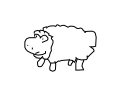

In [24]:
# get a sample drawing from the test set, and render it to .svg
stroke = test_set.random_sample()
draw_strokes(stroke)

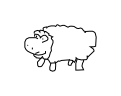

In [26]:
z = encode(stroke)

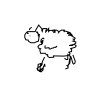

In [27]:
_ = decode(z, temperature=0.8) # convert z back to drawing at temperature of 0.8

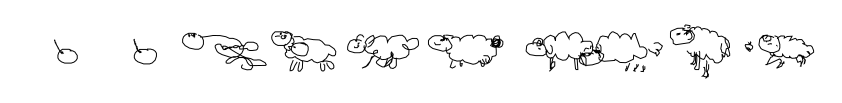

In [28]:
stroke_list = []
for i in range(10):
  stroke_list.append([decode(z, draw_mode=False, temperature=0.1*i+0.1), [0, i]])
stroke_grid = make_grid_svg(stroke_list)
draw_strokes(stroke_grid)

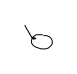

In [29]:
# get a sample drawing from the test set, and render it to .svg
z0 = z
_ = decode(z0)

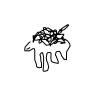

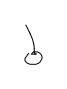

In [30]:
stroke = test_set.random_sample()
z1 = encode(stroke)
_ = decode(z1)

In [0]:
z_list = [] # interpolate spherically between z0 and z1
N = 10
for t in np.linspace(0, 1, N):
  z_list.append(slerp(z0, z1, t))

In [0]:
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
  reconstructions.append([decode(z_list[i], draw_mode=False), [0, i]])

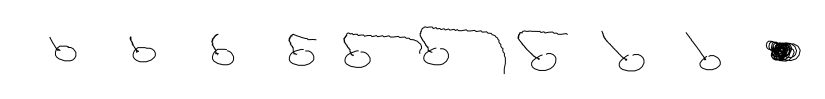

In [33]:
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)